# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

%matplotlib inline
sns.set(font_scale = 1.5)

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('cleanedDF',engine)
X = df['message'].astype(str)
Y = df.loc[:, df.columns != 'message']

### 2. Write a tokenization function to process your text data

In [3]:
# take a look at the structure of the first 10 messages
for i in range(10):
    print(X[i])

Weather update - a cold front from Cuba that could pass over Haiti
Is the Hurricane over or is it not over
Looking for someone but no name
UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
says: west side of Haiti, rest of the country today and tonight
Information about the National Palace-
Storm at sacred heart of jesus
Please, we need tents and water. We are in Silo, Thank you!
I would like to receive the messages, thank you
I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )


In [4]:
# create contraction dictionary
contractions = {"aren\'t": "are not","can\'t": "cannot","can\'t\'ve": "cannot have","\'cause": "because",
                "could\'ve": "could have", "couldn\'t": "could not","couldn\'t\'ve": "could not have","c\'mon": "come on",
                "didn\'t": "did not","doesn\'t": "does not","don\'t": "do not","hadn\'t": "had not",
                "hadn\'t\'ve": "had not have","hasn\'t": "has not","haven\'t": "have not","he\'d": "he had ",
                "he\'d\'ve": "he would have","he\'ll": "he will","he\'s": "he is","here\'s": "here is",
                "how\'d": "how did","how\'d\'y": "how do you","how\'ll": "how will","how\'s": "how is","i\'d": "i would",
                "i\'d\'ve": "i would have","i\'ll": "i will","i\'ll\'ve": "i will have","i\'m": "i am","i\'ve": "i have",
                "isn\'t": "is not","it\'d": "it had","it\'d\'ve": "it would have","it\'ll": "it will",
                "it\'ll\'ve": "it will have","it\'s": "it is","let\'s": "let us","gonna": "going to","ma\'am": "madam",
                "mayn\'t": "may not","might\'ve": "might have","mightn\'t": "might not","mightn\'t\'ve": "might not have",
                "must\'ve": "must have","mustn\'t": "must not","mustn\'t\'ve": "must not have","needn\'t": "need not",
                "needn\'t\'ve": "need not have","o\'clock": "of the clock","oughtn\'t": "ought not",
                "oughtn\'t\'ve": "ought not have","shan\'t": "shall not","sha'n\'t": "shall not",
                "shan't\'ve": "shall not have","she\'d": "she had","she\'d\'ve": "she would have","she\'ll": "she will",
                "she\'ll\'ve": "she will have","she\'s": "she is","should\'ve": "should have","shouldn\'t": "should not",
                "shouldn\'t\'ve": "should not have","so\'ve": "so have","so\'s": "so is","that\'d": "that would",
                "that\'d\'ve": "that would have","that\'s": "that is","there\'d": "there had",
                "there\'d\'ve": "there would have","there\'s": "there is","there\'ve": "there have","they\'d": "they had",
                "they\'d\'ve": "they would have","they\'ll": "they will","they\'ll\'ve": "they will have",
                "they\'re": "they are","they\'ve": "they have","to\'ve": "to have","wasn\'t": "was not","we\'d": "we would",
                "we\'d\'ve": "we would have","we\'ll": "we will","we\'ll\'ve": "we will have","we\'re": "we are",
                "we\'ve": "we have","weren\'t": "were not","what\'ll": "what will",
                "what\'ll\'ve": "what will have","what\'re": "what are","what\'s": "what is","what\'ve": "what have",
                "when\'s": "when is","when\'ve": "when have","where\'d": "where did","where\'s": "where is",
                "where\'ve": "where have","who\'ll": "who will","who\'ll\'ve": "who will have","who\'s": "who is",
                "who\'ve": "who have","why\'s": "why is","why\'ve": "why have","will\'ve": "will have","shall": 'will',
                "won\'t": "will not","won\'t\'ve": "will not have","would\'ve": "would have","wouldn\'t": "would not",
                "wouldn\'t\'ve": "would not have","wanna": "want to","y\'all": "you all","y\'all\'d": "you all would",
                "y\'all\'d\'ve": "you all would have","y\'all\'re": "you all are","y\'all\'ve": "you all have",
                "you\'d": "you would","you\'d\'ve": "you would have","you\'ll": "you will","you\'ll\'ve": "you will have",
                "you\'re": "you are","you\'ve": "you have"
               }
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, cdict=contractions):
    def replace(match):
        return cdict[match.group(0)]
    return contractions_re.sub(replace, s.lower())

In [5]:
def tokenize(text):
    # clear any contractions
    text= expand_contractions(text, cdict=contractions)
    
    # create regex patterns to be removed
    ptn1 = '\s{1}\-{1}\s{1}|[\(,.:\';)!"?/]|\-{1}\s{1}'

    # substitute pattern with white space
    text = re.sub(ptn1, ' ', text)
    
    # tokenize each row
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
])   

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [7]:
# split the data into training and testing subsets 70/30, 
# set random state to ensure the results are reproducible 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 212)

## Overview of Training Data Set

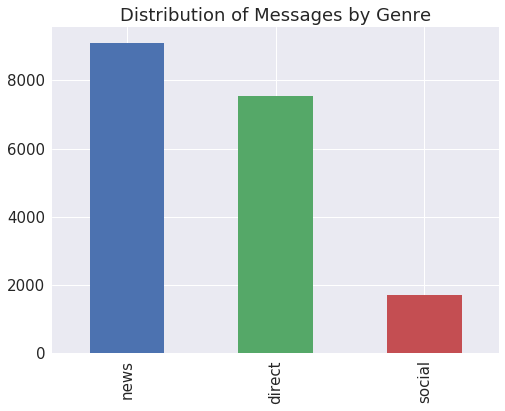

In [8]:
# plotting the distribution of traning data by genre
Y_train.genre.value_counts().plot(kind='bar', figsize= (8,6));
plt.title('Distribution of Messages by Genre');

In [9]:
# drop the genre column in both the training and testing data sets
Y_train = Y_train.drop(columns=['genre'])
Y_test = Y_test.drop(columns=['genre'])

In [10]:
# train classifier
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [11]:
# predict on test data
y_pred = pipeline.predict(X_test)

In [12]:
# iterate through to print report
i =0
for col in Y_test.columns:
    print(col)
    print('_'*80)
    print(classification_report(Y_test[col], y_pred[:,i]))
    print("Confusion Matrix:\n", confusion_matrix(Y_test[col], y_pred[:,i]))
    print("\n")
    print("Accuracy: {0:.3f}".format((Y_test[col] == y_pred[:,i]).mean()))
    print("\n")
    i += 1

related
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.63      0.37      0.46      1836
          1       0.82      0.93      0.87      5964
          2       0.56      0.35      0.43        65

avg / total       0.78      0.80      0.77      7865

Confusion Matrix:
 [[ 675 1158    3]
 [ 394 5555   15]
 [   6   36   23]]


Accuracy: 0.795


request
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.88      0.99      0.93      6505
          1       0.84      0.35      0.50      1360

avg / total       0.87      0.88      0.85      7865

Confusion Matrix:
 [[6416   89]
 [ 883  477]]


Accuracy: 0.876


offer
________________________________________________________________________________
             precision    recall  f1-score   support

          0       1.00      1.00      


Confusion Matrix:
 [[7073   65]
 [ 223  504]]


Accuracy: 0.963


cold
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      7679
          1       0.64      0.04      0.07       186

avg / total       0.97      0.98      0.97      7865

Confusion Matrix:
 [[7675    4]
 [ 179    7]]


Accuracy: 0.977


other_weather
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      7476
          1       0.64      0.05      0.09       389

avg / total       0.94      0.95      0.93      7865

Confusion Matrix:
 [[7466   10]
 [ 371   18]]


Accuracy: 0.952


direct_report
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.85      0.98      0.9

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [13]:
# first check the parameters that were used in the previous model
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f407ac246a8>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

In [14]:
# create the parameters 
parameters = {'vect__max_df': [0.5, 0.75],
              'clf__estimator__min_samples_leaf': [3, 5]
             }

cv = GridSearchCV(pipeline, param_grid = parameters)

In [15]:
# train the tuned model
cv.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_df': [0.5, 0.75], 'clf__estimator__min_samples_leaf': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [17]:
# take a look at the best parameters
cv.best_params_

{'clf__estimator__min_samples_leaf': 3, 'vect__max_df': 0.5}

In [19]:
# predict on test data
y_pred2 = cv.predict(X_test)

In [20]:
# iterate through to print report
i =0
for col in Y_test.columns:
    print(col)
    print('_'*80)
    print(classification_report(Y_test[col], y_pred2[:,i]))
    print("Confusion Matrix:\n", confusion_matrix(Y_test[col], y_pred2[:,i]))
    print("\n")
    print("Accuracy: {0:.3f}".format((Y_test[col] == y_pred2[:,i]).mean()))
    print("\n")
    i += 1

related
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.70      0.18      0.29      1836
          1       0.79      0.98      0.87      5964
          2       0.75      0.09      0.16        65

avg / total       0.77      0.78      0.73      7865

Confusion Matrix:
 [[ 337 1499    0]
 [ 141 5821    2]
 [   1   58    6]]


Accuracy: 0.784


request
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      6505
          1       0.89      0.22      0.36      1360

avg / total       0.87      0.86      0.82      7865

Confusion Matrix:
 [[6469   36]
 [1056  304]]


Accuracy: 0.861


offer
________________________________________________________________________________
             precision    recall  f1-score   support

          0       1.00      1.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion Matrix:
 [[7585    0]
 [ 280    0]]


Accuracy: 0.964


death
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7510
          1       0.85      0.03      0.06       355

avg / total       0.95      0.96      0.94      7865

Confusion Matrix:
 [[7508    2]
 [ 344   11]]


Accuracy: 0.956


other_aid
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.87      1.00      0.93      6844
          1       1.00      0.00      0.01      1021

avg / total       0.89      0.87      0.81      7865

Confusion Matrix:
 [[6844    0]
 [1017    4]]


Accuracy: 0.871


infrastructure_related
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.94      1.00    

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [22]:
# create second pipeline
pipeline2 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

# train new model
pipeline2.fit(X_train, Y_train)

# run prediction
y_pred3 = pipeline2.predict(X_test)

In [23]:
# iterate through to print report
i =0
for col in Y_test.columns:
    print(col)
    print('_'*80)
    print(classification_report(Y_test[col], y_pred3[:,i]))
    print("Confusion Matrix:\n", confusion_matrix(Y_test[col], y_pred3[:,i]))
    print("\n")
    print("Accuracy: {0:.3f}".format((Y_test[col] == y_pred3[:,i]).mean()))
    print("\n")
    i += 1

related
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.56      0.22      0.32      1836
          1       0.79      0.95      0.86      5964
          2       0.46      0.25      0.32        65

avg / total       0.74      0.77      0.73      7865

Confusion Matrix:
 [[ 407 1423    6]
 [ 315 5636   13]
 [   3   46   16]]


Accuracy: 0.770


request
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      6505
          1       0.79      0.54      0.64      1360

avg / total       0.89      0.90      0.89      7865

Confusion Matrix:
 [[6316  189]
 [ 630  730]]


Accuracy: 0.896


offer
________________________________________________________________________________
             precision    recall  f1-score   support

          0       1.00      1.00      

 [[7654   25]
 [ 140   46]]


Accuracy: 0.979


other_weather
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      7476
          1       0.50      0.17      0.25       389

avg / total       0.94      0.95      0.94      7865

Confusion Matrix:
 [[7409   67]
 [ 323   66]]


Accuracy: 0.950


direct_report
________________________________________________________________________________
             precision    recall  f1-score   support

          0       0.88      0.96      0.92      6328
          1       0.73      0.47      0.57      1537

avg / total       0.85      0.86      0.85      7865

Confusion Matrix:
 [[6062  266]
 [ 818  719]]


Accuracy: 0.862




### 9. Export your model as a pickle file

In [25]:
# saving model to pickle file
import pickle
pickle_path = 'classifier.pkl'

pickle_var = open(pickle_path, 'wb')
pickle.dump(pipeline2, pickle_var)
pickle_var.close()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.